# Transfer Learning

### Aufgabe
_Wählen Sie nun 5 andere Hunderassen aus. Nutzen Sie Transfer Learning zur Klassifikation dieser
Rassen, d.h. laden Sie die Gewichte aus Ihrem in Teilaufgabe B5 trainierten Modell als initiale
Gewichte für das neue Training. Beschreiben Sie ihr Vorgehen im Kurzreport und setzen Sie die
Evaluation dieses erneuten Trainings in Relation zu den Evaluationsergebnissen ihres ursprünglichen
Modells._


---

> Aufbau ähnlich zu `deep_learning.ipynb`   
> Doppelte Schritte werden nicht erklärt und sind in dem Deep Learning Notebook genauer erläutert

Also Hunderassen wurden dieses mal

In [1]:
import keras
import tensorflow as tf
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

%matplotlib inline

notebook_dir = Path().resolve()
sys.path.append(str(notebook_dir.parent))

from utils.setup import setup_dataset, generateDatasetArrays
from helper.visualize import visualize_history, visualize_predictions, getDognames

# load configuration
import config as Config

# config overrides
Config.DOG_LABEL_IDS = [42, 23, 85, 99, 12] # 5 andere Hunderassen

2024-12-17 12:39:44.985584: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734435584.996192   93860 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734435584.999266   93860 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 12:39:45.010633: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_dataset, test_dataset, label_lookup_table, info = setup_dataset('../dataset', labels=Config.DOG_LABEL_IDS)

def preprocess(data):
    data["original_image"] = tf.identity(data["image"])
    data["image"] = tf.image.resize(data["image"], Config.RESIZE_SIZE)
    data["label"] = label_lookup_table.lookup(data["label"])
    return data

train_dataset = (
    train_dataset
        .map(preprocess)
        .shuffle(1000)
        .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    test_dataset
        .map(preprocess)
        .shuffle(100)
        .prefetch(tf.data.AUTOTUNE)
)

I0000 00:00:1734435586.890016   93860 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8901 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:08:00.0, compute capability: 8.6
2024-12-17 12:39:46.992165: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2024-12-17 12:39:48.023744: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Total Image count:  500


2024-12-17 12:39:48.794072: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Dataset Size: 375
Test Dataset Size: 125


---

Das trainierte Modell aus dem Deep Learning Teil wurde abgespeichert. Dieses wird nun wieder geladen und die letzten 3 Schichten werden entfernt (da die Schichten davor für die Feature Extraction sind).
Dann werden drei neue Schichten hinzugefügt, welche danach mit den neuen Daten trainiert wurden, um die Zuordnung der Features zu den Klassen neu festzulegen.

In [3]:
model = keras.models.load_model(os.path.join(Config.MODEL_FOLDER, Config.MODEL_FILENAME))

model.pop()
model.pop()
model.pop()

model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.5, name="dense_dropout"))
model.add(keras.layers.Dense(Config.NUM_CLASSES, activation='softmax'))

# Freeze the layers except the last three
for layer in model.layers[:-3]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

**Finetuning**

ss

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 583ms/step - accuracy: 0.9482 - loss: 0.1213 - val_accuracy: 0.4400 - val_loss: 11.0925
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9168 - loss: 0.1699 - val_accuracy: 0.4400 - val_loss: 11.1378
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9279 - loss: 0.2010 - val_accuracy: 0.4480 - val_loss: 10.6161
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9584 - loss: 0.1678 - val_accuracy: 0.4560 - val_loss: 10.6563
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9502 - loss: 0.1153 - val_accuracy: 0.4640 - val_loss: 10.6873
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9630 - loss: 0.1084 - val_accuracy: 0.4400 - val_loss: 10.9612
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9558 - loss: 0.1845 - val_accuracy: 0.4640 - val_loss: 10.6876
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9441 - loss: 0.1203 - val_accuracy: 0

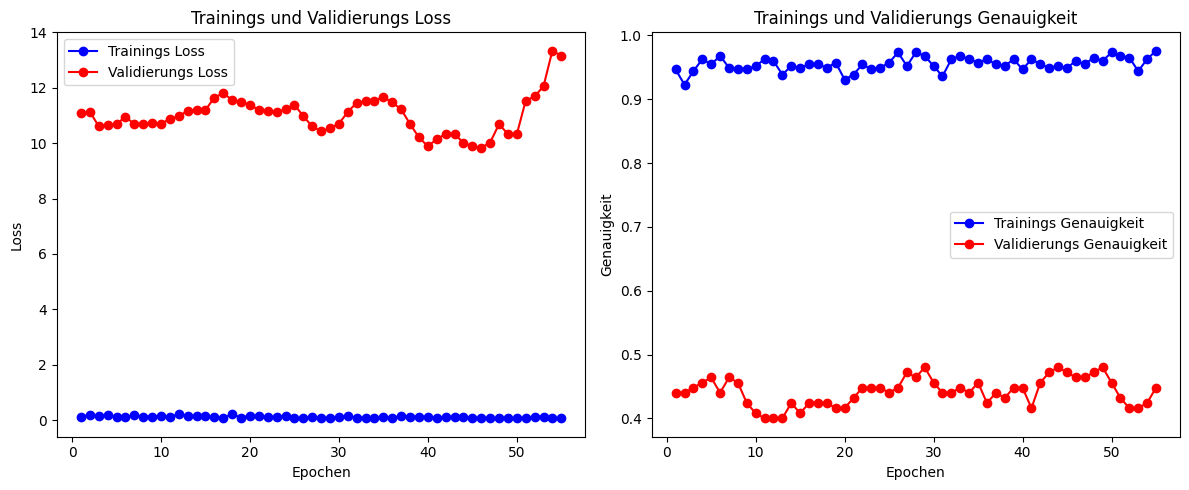

In [6]:
images, labels = generateDatasetArrays(train_dataset)
images_test, labels_test = generateDatasetArrays(test_dataset)

history = model.fit(
    images, labels,
    validation_data=(images_test, labels_test),
    epochs=50,
    batch_size=Config.BATCH_SIZE,
    verbose=1 if Config.DEBUG else 0
)

# Feinabstimmung des gesamten Modells
for layer in model.layers:
    layer.trainable = True  # Alle Schichten freigeben

# Reduzierte Lernrate für Fine-Tuning
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
print("Finetuning des gesamten Modells")
history_finetune = model.fit(
    images, labels,
    validation_data=(images_test, labels_test),
    epochs=5,
    batch_size=16,
    verbose=1 if Config.DEBUG else 0
)

loss, acc = model.evaluate(images_test, labels_test, verbose=0)
print('Test accuracy: %.3f' % acc) 

# Kombinieren der Trainingsergebnisse, damit das Trainieren der letzten Ebenenen, sowie das Feintuning in einem Graph visualisiert wird
for key in history.history.keys():
    history.history[key].extend(history_finetune.history[key])

visualize_history(history.history)

model.save(os.path.join(Config.MODEL_FOLDER, Config.TRANSFER_MODEL_FILENAME))

# Evaluation Transfer Learning (Aufgabe 6)

Trotz dessen hat das neue Modell mit den neuen Hunderassen eine schlechtere Genauigkeit (0,68(neues Modell) zu 0,71(altes Modell)), dieser Unterschied wäre eigentlich noch stärker, da bei diesem Modell die ausgewählten Hunderassen ungefähr gleich viele Bilder haben (was ja bei Aufgabe 5 nicht der Fall war).

Der Grund warum dieses Modell trotzdem schlechter abschneidet ist vermutlich unter anderem, weil die Feature Exraction auf die Hunde des ersten Modells angepasst ist.

Test accuracy (Deep Learning): 0.200
Test accuracy (Transfer Learning): 0.440


2024-12-17 12:40:52.932601: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


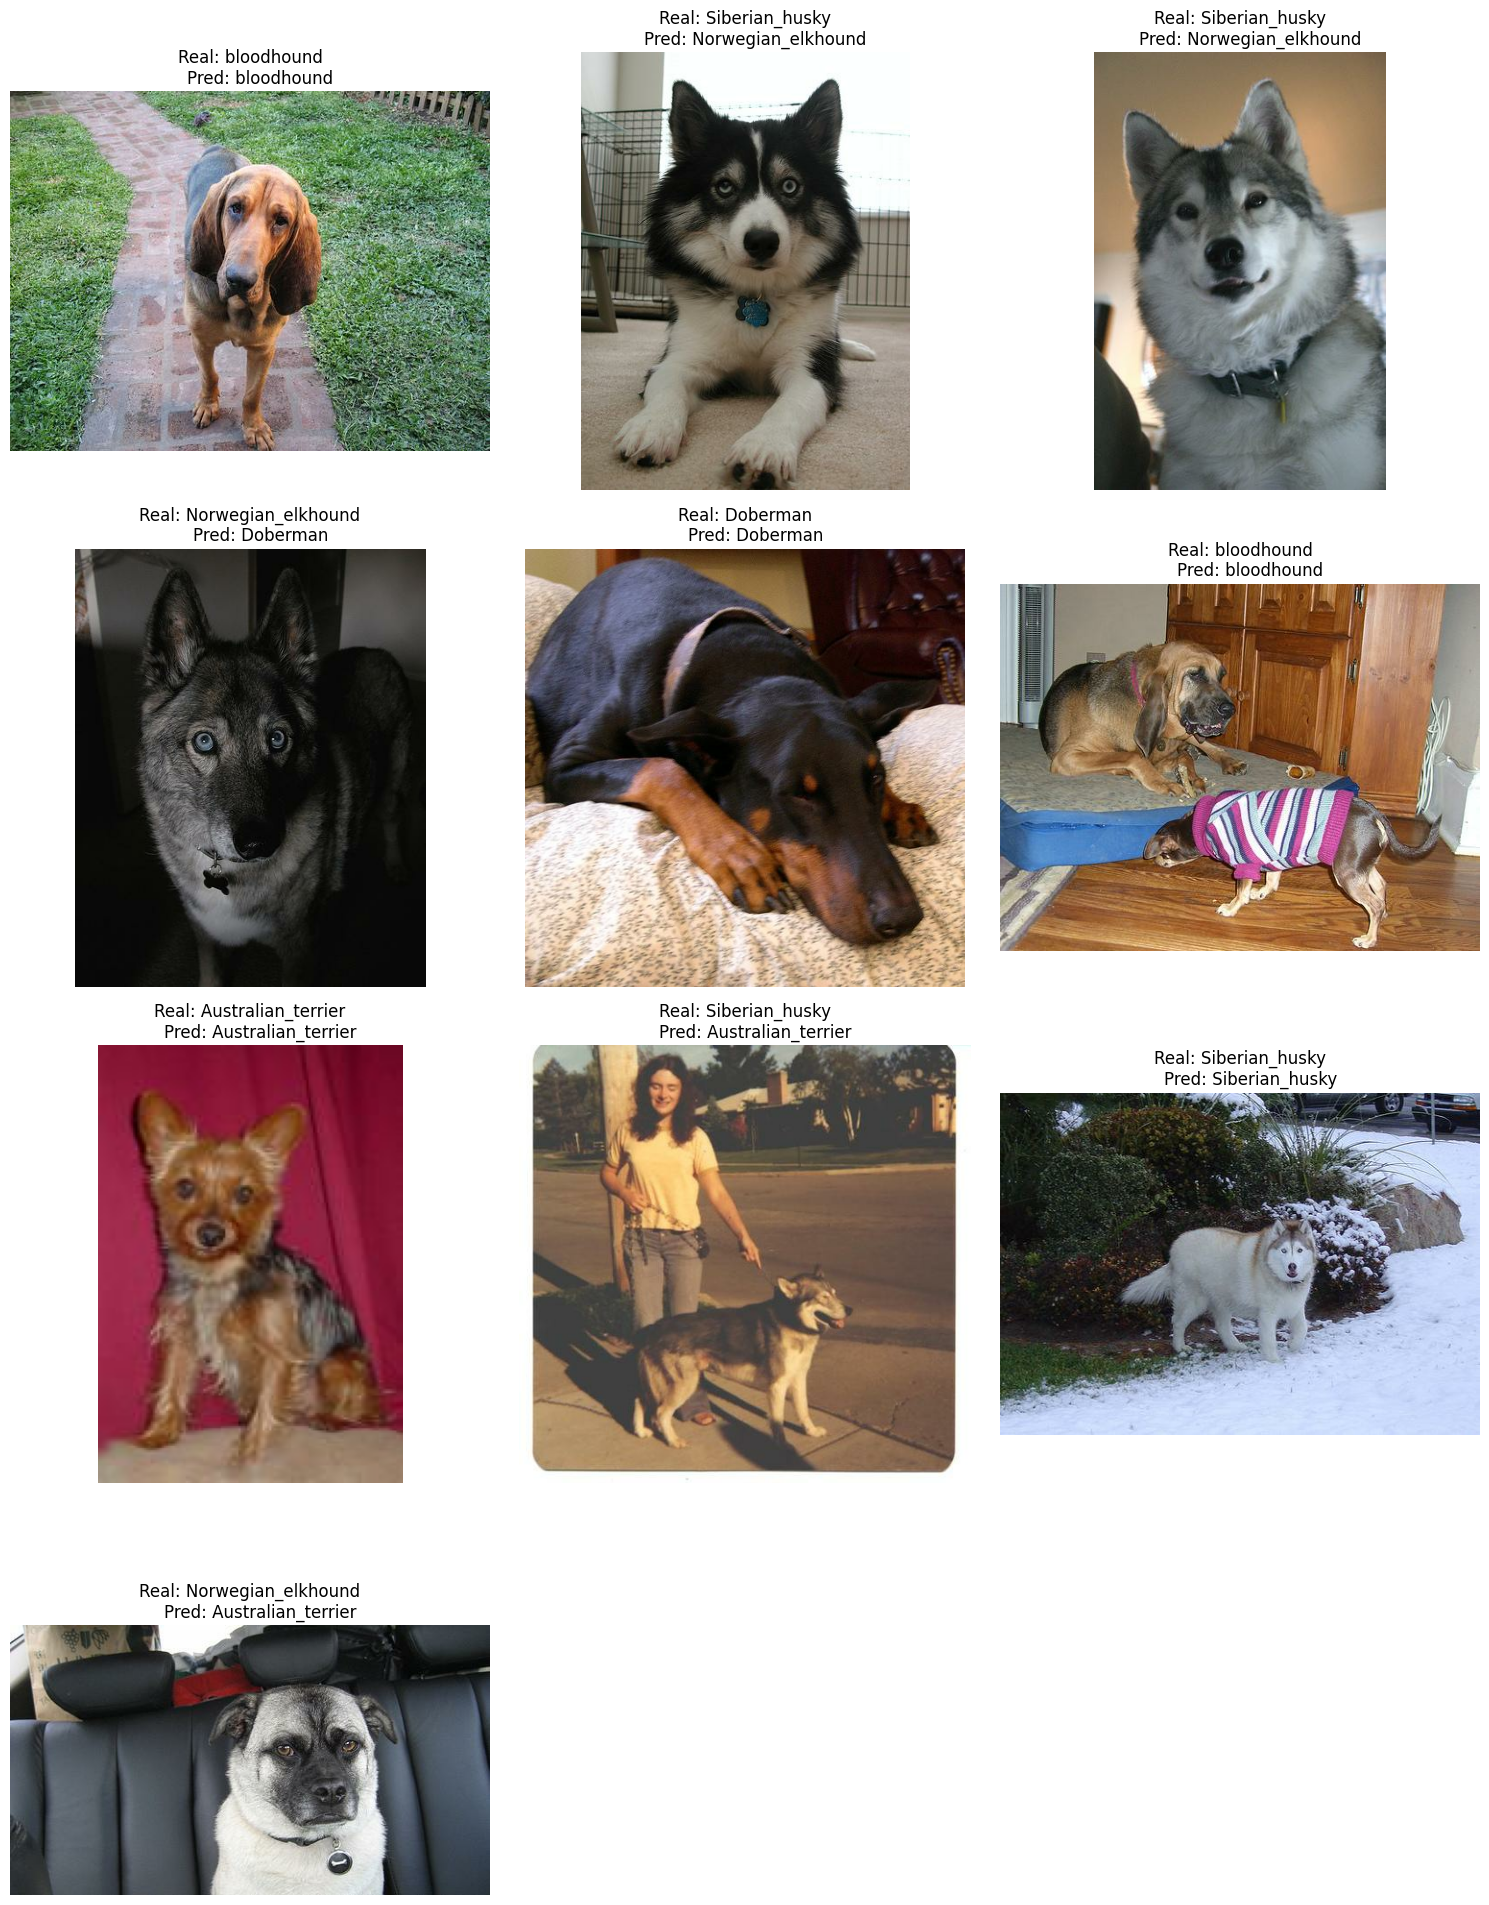

In [5]:
model = keras.models.load_model(os.path.join(Config.MODEL_FOLDER, Config.MODEL_FILENAME))
loss, acc = model.evaluate(images_test, labels_test, verbose=0)
print('Test accuracy (Deep Learning): %.3f' % acc) 

model = keras.models.load_model(os.path.join(Config.MODEL_FOLDER, Config.TRANSFER_MODEL_FILENAME))
loss, acc = model.evaluate(images_test, labels_test, verbose=0)
print('Test accuracy (Transfer Learning): %.3f' % acc) 

visualize_predictions(
    os.path.join(Config.MODEL_FOLDER, Config.TRANSFER_MODEL_FILENAME),
    test_dataset
)